<a href="https://colab.research.google.com/github/Srieswari/deforestation-/blob/main/deforestation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
#installing kaggle
! pip install -q kaggle

In [3]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"srieswari","key":"e08f82162c6c89727f1d9b0452d3987b"}'}

In [4]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/

In [5]:
! chmod 600 ~/.kaggle/kaggle.json

In [6]:
#downloading the dataset from kaggle
! kaggle datasets download prosperchuks/amazonsatelliteimages

100% 1.50G/1.50G [01:09<00:00, 25.2MB/s]
100% 1.50G/1.50G [01:09<00:00, 23.1MB/s]


In [ ]:
! unzip /content/amazonsatelliteimages.zip

In [8]:
#import the necessary libraries
import numpy as np
import tensorflow as tf
import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from tensorflow.keras.metrics import AUC
from tensorflow.keras.metrics import Metric, Precision, Recall
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model

In [9]:
#here we r using ResNet 50
base_model = ResNet50(weights='imagenet', include_top=False)

94765736/94765736 [==============================] - 4s 0us/step


In [10]:
labels_df = pd.read_csv("/content/train_v2.csv/train_v2.csv")

In [11]:
labels_df['deforestation'] = labels_df['tags'].apply(lambda x: 1 if 'habitation' in x else 0)
labels_df['pollution'] = labels_df['tags'].apply(lambda x: 1 if 'slash_burn' in x else 0)

In [12]:
train_df, val_df = train_test_split(labels_df, test_size=0.2, random_state=42)

In [13]:
train_df['image_name'] = train_df['image_name'].apply(lambda x: f"{x}.jpg")
val_df['image_name'] = val_df['image_name'].apply(lambda x: f"{x}.jpg")

In [14]:
#forming train , validation sets
def create_dataset_generator(df, data_dir, batch_size=32, target_size=(224, 224)):
    datagen = ImageDataGenerator(rescale=1./255)
    generator = datagen.flow_from_dataframe(
        df, directory=data_dir, x_col='image_name', y_col=['deforestation', 'pollution'],
        target_size=target_size, batch_size=batch_size, class_mode='raw')
    return generator

# Set the path to dataset directory
data_dir = '/content/train-jpg/train-jpg'

# Create dataset generators for training and validation sets
train_generator = create_dataset_generator(train_df, data_dir)
val_generator = create_dataset_generator(val_df, data_dir)

Found 32383 validated image filenames.
Found 8096 validated image filenames.


In [15]:
#adding layers such as dropout,dense,pooling
from tensorflow.keras.layers import Dropout

# Add dropout layers to the model
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(2048, activation='relu')(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(2, activation='sigmoid')(x)

# Create final model
model = Model(inputs=base_model.input, outputs=predictions)

In [16]:
#compiling the model
for layer in base_model.layers:
    layer.trainable = False

# Compile model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[AUC(name='auc')])

In [17]:
history = model.fit(train_generator, epochs=3, validation_data=val_generator)

Epoch 1/3
1012/1012 [==============================] - 178s 160ms/step - loss: 0.1705 - auc: 0.7683 - val_loss: 0.1615 - val_auc: 0.8791
Epoch 2/3
1012/1012 [==============================] - 145s 144ms/step - loss: 0.1579 - auc: 0.8097 - val_loss: 0.1524 - val_auc: 0.8836
Epoch 3/3
1012/1012 [==============================] - 159s 157ms/step - loss: 0.1538 - auc: 0.8267 - val_loss: 0.1622 - val_auc: 0.8782


In [25]:
from tensorflow.keras.preprocessing import image

#creating a function to make predictions
def predict_deforestation(model, img_path, img_size=(224, 224)):
    img = image.load_img(img_path, target_size=img_size)
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = x / 255.0

    # Make a prediction using model
    preds = model.predict(x)

    return preds

In [26]:
import os
import random
import matplotlib.pyplot as plt

#creating a function to display the predicted images
def display_image(img_path, deforestation_prob, pollution_prob):
    img = image.load_img(img_path)

    plt.figure()
    plt.imshow(img)
    plt.title(f"Deforestation Probability: {deforestation_prob:.4f}")
    plt.axis("off")
    plt.show()


In [27]:
#choose few images for testing
test_data_dir = '/content/test-jpg/test-jpg'

test_images = random.sample(os.listdir(test_data_dir), 3)

1/1 [==============================] - 0s 25ms/step


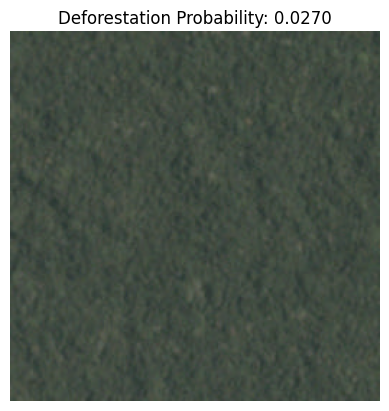

1/1 [==============================] - 0s 28ms/step


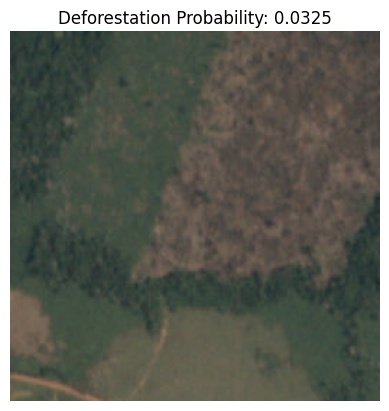

1/1 [==============================] - 0s 23ms/step


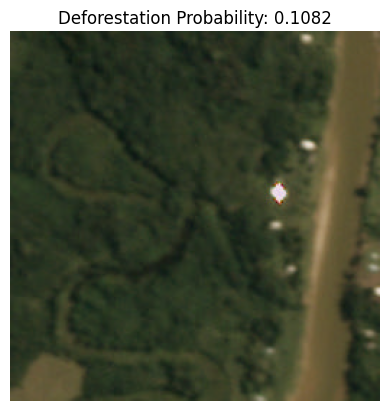

In [28]:
for img_name in test_images:
    img_path = os.path.join(test_data_dir, img_name)
    preds = predict_deforestation(model, img_path)

    deforestation_prob = preds[0][0]
    pollution_prob = preds[0][1]

    display_image(img_path, deforestation_prob, pollution_prob)